# 库导入

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sco
from joblib import Parallel, delayed
import multiprocessing
import datetime
import statsmodels.api as sm
import seaborn
from sklearn.metrics import classification_report
import talib as ta
import time
import scipy

from scipy import stats

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
pd.set_option('display.width',1000)

# 相关交易日

## 交易日期数据

In [2]:
TradeDateDf = pd.read_csv('D:/DWDB/%s.csv'%('AShareCalendar'))
TradeDateDf = TradeDateDf[TradeDateDf['S_INFO_EXCHMARKET'] == 'SSE']
TradeDateDf_D = TradeDateDf['TRADE_DAYS'].apply(lambda x:datetime.datetime.strptime(str(x),'%Y%m%d')).to_frame('TRADE_DAYS').sort_values('TRADE_DAYS')

TradeDateDf_D_Used = TradeDateDf_D[(TradeDateDf_D['TRADE_DAYS']>='2005-01-01') & (TradeDateDf_D['TRADE_DAYS']<='2019-07-31')]
TradeDateDf_D_Used.index = TradeDateDf_D_Used['TRADE_DAYS']
TradeDateDf_D_Used.index.names = ['NOT_TRADE_DAYS']

TradeDateDf_M_Used = TradeDateDf_D_Used.resample('M').last()
TradeDateDf_M_Used.index.names = ['NOT_TRADE_DAYS']

## 日期转换函数

In [3]:
# 月度非标准数据的日期转变为当月（若t>t_end，下个月）最后一个交易日
def MdateToMENDdate(FinancialIndicatorDf,TradeDateDf_M_Used,colname):
    '''
    第1参数，DF，包含 colname 列，公告日期，
    第2参数，DF，包含 TRADE_DAYS 列，为月度交易日，
    '''
    FinancialIndicatorDf_1 = FinancialIndicatorDf.copy()
    FinancialIndicatorDf_end = FinancialIndicatorDf.copy()
    ## 可更改，根据ANN_DT列是否为日期
    try:
        FinancialIndicatorDf_1['TRADE_DAYS_tmp'] = FinancialIndicatorDf_1[colname].apply(lambda x:datetime.datetime.strptime(str(x),'%Y%m%d'))
    except:
        FinancialIndicatorDf_1['TRADE_DAYS_tmp'] = FinancialIndicatorDf_1[colname]
    #################################
    TradeDateDf_M_Used_ = TradeDateDf_M_Used.copy()
    TradeDateDf_M_Used_['TRADE_DAYS_Y_M'] = [each.strftime('%Y-%m-%d')[:7] for each in TradeDateDf_M_Used['TRADE_DAYS'].tolist()].copy()
    FinancialIndicatorDf_1['TRADE_DAYS_Y_M'] = [each.strftime('%Y-%m-%d')[:7] for each in FinancialIndicatorDf_1['TRADE_DAYS_tmp'].tolist()]
    FinancialIndicatorDf_2 = FinancialIndicatorDf_1.merge(TradeDateDf_M_Used_,on=['TRADE_DAYS_Y_M'],how='left')
    TradeDateDf_M_Used_DateList = TradeDateDf_M_Used_['TRADE_DAYS'].tolist()
    FinancialIndicatorDf_3 = FinancialIndicatorDf_2.copy()
#     FinancialIndicatorDf_3['TRADE_DAYS'] = FinancialIndicatorDf_3.apply(lambda x: 
#                                                                         TradeDateDf_M_Used_DateList[TradeDateDf_M_Used_DateList.index(x['TRADE_DAYS'])+1] 
#                                                                         if x['TRADE_DAYS_tmp']>x['TRADE_DAYS'] 
#                                                                         else x['TRADE_DAYS'] ,axis=1)
    FinancialIndicatorDf_end[colname]= FinancialIndicatorDf_3.apply(lambda x: 
                                                                        TradeDateDf_M_Used_DateList[TradeDateDf_M_Used_DateList.index(x['TRADE_DAYS'])+1] 
                                                                        if x['TRADE_DAYS_tmp']>x['TRADE_DAYS'] 
                                                                        else x['TRADE_DAYS'] ,axis=1)
    return FinancialIndicatorDf_end

# 股票池筛选

## 获取全股票池

In [4]:
# 以行情信息对应的日度股票列表筛选得到月度可选股列表
DfForStock = pd.read_csv('D:/DWDB/%s.csv'%('AShareEODPrices'))
DfForStock_0 = DfForStock[['S_INFO_WINDCODE','TRADE_DT']].copy()
DfForStock_0['TRADE_DAYS'] = DfForStock_0['TRADE_DT'].apply(lambda x:datetime.datetime.strptime(str(x),'%Y%m%d'))
DfForStock_0=DfForStock_0[['S_INFO_WINDCODE','TRADE_DAYS']].copy()

In [5]:
# 日度股票列表月度化
DfForStock_1=DfForStock_0.set_index('TRADE_DAYS')
DfForStock_1['TRADE_DAYS']=DfForStock_1.index
DfForStock_2=DfForStock_1.groupby('S_INFO_WINDCODE').apply(lambda x:x.resample('M').last())
DfForStock_3=DfForStock_2.reset_index(drop=True)

## 删除上市未满6个月股票

In [6]:
IPODF = pd.read_csv('D:/DWDB/%s.csv'%'AShareIPO')
IPODF['S_IPO_LISTDATE']=IPODF['S_IPO_LISTDATE'].apply(lambda x:datetime.datetime.strptime(str(int(x)),'%Y%m%d') if not np.isnan(x) else np.nan)
IPODF_0 = IPODF[['S_INFO_WINDCODE','S_IPO_LISTDATE']]

DfForStock_4 = DfForStock_3.merge(IPODF_0,on=['S_INFO_WINDCODE'],how='left')
DfForStock_4['IPOtitlNow'] = DfForStock_4['TRADE_DAYS']-DfForStock_4['S_IPO_LISTDATE']
DfForStock_4['IPOtitlNowIF'] = DfForStock_4['IPOtitlNow'].apply(lambda x: 1 if x.days>182 else 0)

DfForStock_5 = DfForStock_4[DfForStock_4['IPOtitlNowIF']==1][['S_INFO_WINDCODE','TRADE_DAYS']].copy()

## 删除有特殊处理的股票

In [7]:
STDF = pd.read_csv('D:/DWDB/%s.csv'%'AShareST')
STDF['ENTRY_DT'] = STDF['ENTRY_DT'].apply(lambda x:datetime.datetime.strptime(str(int(x)),'%Y%m%d') if not np.isnan(x) else np.nan)
STDF['REMOVE_DT'] = STDF['REMOVE_DT'].apply(lambda x:datetime.datetime.strptime(str(int(x)),'%Y%m%d') if not np.isnan(x) else np.nan)
STDF_0 = STDF[['S_INFO_WINDCODE','ENTRY_DT','REMOVE_DT','S_TYPE_ST']].copy()
STDF_0['REMOVE_DT'] = STDF_0['REMOVE_DT'].fillna(datetime.datetime.strptime('2099-12-31','%Y-%m-%d'))

In [8]:
DfForStock_6=DfForStock_5.merge(STDF_0,left_on=['TRADE_DAYS','S_INFO_WINDCODE'],right_on=['ENTRY_DT','S_INFO_WINDCODE'],how='left')
DfForStock_6=DfForStock_6[DfForStock_6['ENTRY_DT'].isnull()][['TRADE_DAYS','S_INFO_WINDCODE']].copy()
DfForStock_7=DfForStock_6.merge(MdateToMENDdate(STDF_0,TradeDateDf_M_Used,'ENTRY_DT'),left_on=['TRADE_DAYS','S_INFO_WINDCODE'],right_on=['ENTRY_DT','S_INFO_WINDCODE'],how='left')

In [9]:
def FillNaT(df):
    df_=df.sort_values('TRADE_DAYS').copy()
    df_=df_.fillna(method='ffill')
    return df_
DfForStock_8=DfForStock_7.groupby('S_INFO_WINDCODE').apply(FillNaT).reset_index(drop=True)

In [10]:
DfForStock_9=DfForStock_8[~(DfForStock_8['TRADE_DAYS']<=DfForStock_8['REMOVE_DT'])][['S_INFO_WINDCODE','TRADE_DAYS']].copy()

## 剔除停牌股票

In [11]:
TradingSuspensionDF = pd.read_csv('D:/DWDB/%s.csv'%'AShareTradingSuspension')
TradingSuspensionDF_0 = TradingSuspensionDF[['S_INFO_WINDCODE','S_DQ_SUSPENDDATE','S_DQ_RESUMPDATE']].copy()
TradingSuspensionDF_0['S_DQ_SUSPENDDATE']=TradingSuspensionDF_0['S_DQ_SUSPENDDATE'].apply(lambda x:datetime.datetime.strptime(str(int(x)),'%Y%m%d') if not np.isnan(x) else np.nan)
TradingSuspensionDF_0['S_DQ_RESUMPDATE']=TradingSuspensionDF_0['S_DQ_RESUMPDATE'].apply(lambda x:datetime.datetime.strptime(str(int(x)),'%Y%m%d') if not np.isnan(x) else np.nan)

TradingSuspensionDF_1=TradingSuspensionDF_0.copy()
TradingSuspensionDF_1['S_DQ_RESUMPDATE']=TradingSuspensionDF_1.apply(lambda x: x['S_DQ_SUSPENDDATE'] if pd.isnull(x['S_DQ_RESUMPDATE']) else x['S_DQ_RESUMPDATE'],axis=1)

TradingSuspensionDF_2=MdateToMENDdate(TradingSuspensionDF_1,TradeDateDf_M_Used,'S_DQ_SUSPENDDATE')
TradingSuspensionDF_3=TradingSuspensionDF_2[~(TradingSuspensionDF_2['S_DQ_SUSPENDDATE']>TradingSuspensionDF_2['S_DQ_RESUMPDATE'])]

DfForStock_10=DfForStock_9.merge(TradingSuspensionDF_3,left_on=['TRADE_DAYS','S_INFO_WINDCODE'],right_on=['S_DQ_SUSPENDDATE','S_INFO_WINDCODE'],how='left')
DfForStock_11=DfForStock_10.groupby('S_INFO_WINDCODE').apply(FillNaT).reset_index(drop=True)
DfForStock_12=DfForStock_11[~(DfForStock_11['TRADE_DAYS']<=DfForStock_11['S_DQ_RESUMPDATE'])][['S_INFO_WINDCODE','TRADE_DAYS']].copy()

DfForStock_V = DfForStock_12.copy()

# 动量因子计算
## 多窗口动量因子

In [17]:
AllPriceData=DfForStock.copy()
AllPriceData_0 = AllPriceData[['S_INFO_WINDCODE','TRADE_DT','S_DQ_ADJCLOSE']].copy()
AllPriceData_0['TRADE_DAYS'] = AllPriceData_0['TRADE_DT'].apply(lambda x:datetime.datetime.strptime(str(int(x)),'%Y%m%d') if not pd.isnull(x) else np.nan)
AllPriceData_1=AllPriceData_0[['S_INFO_WINDCODE','TRADE_DAYS','S_DQ_ADJCLOSE']].copy()

In [18]:
AllPriceData_1.head()

,S_INFO_WINDCODE,TRADE_DAYS,S_DQ_ADJCLOSE
0,000878.SZ,2005-01-04,8.12
1,000880.SZ,2005-01-04,9.12
2,000881.SZ,2005-01-04,14.03
3,000882.SZ,2005-01-04,5.70
4,000883.SZ,2005-01-04,5.29


In [19]:
# 个股行情数据，个股收益率
DfForRet=AllPriceData_1[['S_INFO_WINDCODE','TRADE_DAYS','S_DQ_ADJCLOSE']].copy()
def ComputeRet(df,datename,colname):
    df_=df.sort_values(datename).copy()
    df_['Ret']=df_[colname]/df_[colname].shift(1)-1
    return df_
DfForRet_0=DfForRet.groupby('S_INFO_WINDCODE').apply(ComputeRet,datename='TRADE_DAYS',colname='S_DQ_ADJCLOSE').reset_index(drop=True)

In [20]:
def ComputeMom(df):
    df_=df.sort_values('TRADE_DAYS').copy()
    Rprod=np.exp(np.log(df_['Ret'][-MomN:]+1).sum())-1
    return pd.DataFrame([df_['S_INFO_WINDCODE'].tolist()[0],Rprod],index=['S_INFO_WINDCODE','Mom_%s'%(MomN)]).T
def applyParallel(dfGrouped, func):
    retLst = Parallel(n_jobs=multiprocessing.cpu_count()-2)(delayed(func)(group) for name, group in dfGrouped)
    return pd.concat(retLst,axis=0)
def ComputeMfWithDData(TradeDateDf_M_Used,DfForRet_2,ComputeBeta,StartN,UsedN):
    '''
    日度数据计算月度因子专用函数
    TradeDateDf_M_Used,循环交易日DF
    DfForRet_2,原材料数据集
    StartN,因子计算起始窗口
    UsedN,因子计算所需数据长度
    '''
    DateList=TradeDateDf_M_Used['TRADE_DAYS']
    SaveDf=pd.DataFrame()
    for DateCnt in range(StartN,len(DateList)):
        DateNow=DateList[DateCnt]
        DateLast=DateList[DateCnt-UsedN]
        DfForRet_2_sub=DfForRet_2[(DfForRet_2['TRADE_DAYS']<=DateNow)&(DfForRet_2['TRADE_DAYS']>=DateLast)].copy()
        DfForRet_2_sub0=DfForRet_2_sub[DfForRet_2_sub['S_INFO_WINDCODE'].isin(DfForStock_V[DfForStock_V['TRADE_DAYS']==DateNow]['S_INFO_WINDCODE'])]
        DfForRet_2_sub1=applyParallel(DfForRet_2_sub0.groupby('S_INFO_WINDCODE'),ComputeBeta)
        DfForRet_2_sub1['TRADE_DAYS']=DateNow
        SaveDf=pd.concat([SaveDf,DfForRet_2_sub1],axis=0)
    return SaveDf

In [22]:
MomDf={}
MomNList=[5,10,20,60,120,240]
for MomN in MomNList:
    MomDf[MomN]=ComputeMfWithDData(TradeDateDf_M_Used,DfForRet_0,ComputeMom,12,6)

In [23]:
MomFct=pd.DataFrame(columns=['S_INFO_WINDCODE','TRADE_DAYS'])
for key in MomDf.keys():
    MomFct_tmp=MomDf[key]
    MomFct=MomFct.merge(MomFct_tmp,on=['S_INFO_WINDCODE','TRADE_DAYS'],how='outer')
MomFct=MomFct.dropna()

In [24]:
for col in ['Mom_'+str(c) for c in MomNList]:
    MomFct[col]=MomFct[col].astype("float")

## 读取Barra因子库

In [35]:
BarraFactorNextR=pd.read_csv('D:/StockDataBase/BarraFactorNextR.csv',parse_dates=['TRADE_DAYS'])
del BarraFactorNextR['EARN']

In [36]:
BarraMomFct=BarraFactorNextR.merge(MomFct,on=['S_INFO_WINDCODE','TRADE_DAYS'],how='left').groupby(['S_INFO_WINDCODE','TRADE_DAYS']).mean().reset_index()

In [43]:
def data_neutral(df):
    df_ = df.copy()
    X = pd.get_dummies(df_[['SIZE','IND']],columns=['IND'])
    FactorNames = ['Mom_'+str(c) for c in MomNList]
    for colname in FactorNames:
        y = df_[[colname]]
        residSeries = sm.OLS(y,X).fit().resid
        df_[colname] = residSeries
    return df_

In [44]:
BarraMomFct_=BarraMomFct.groupby(['TRADE_DAYS']).apply(data_neutral).reset_index(drop=True)

## 普通动量效应

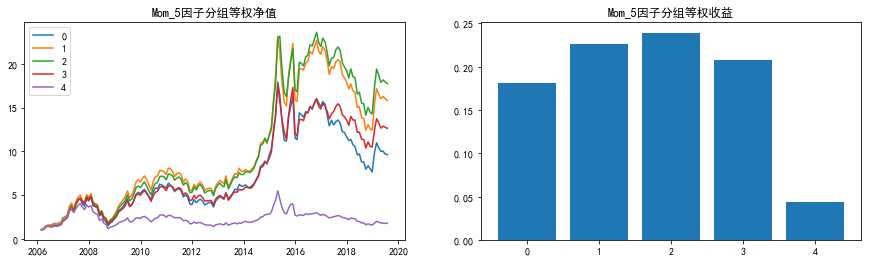

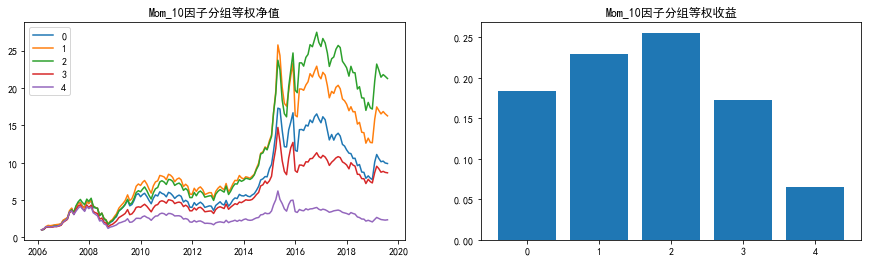

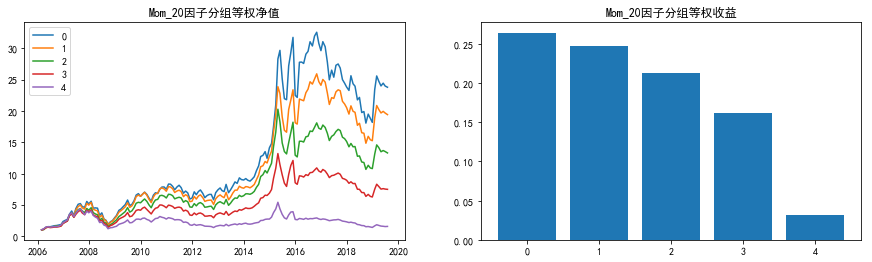

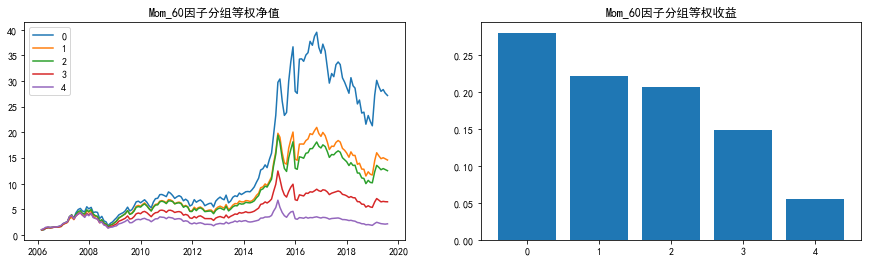

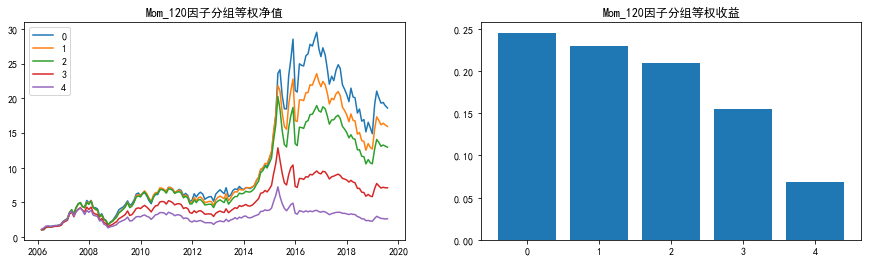

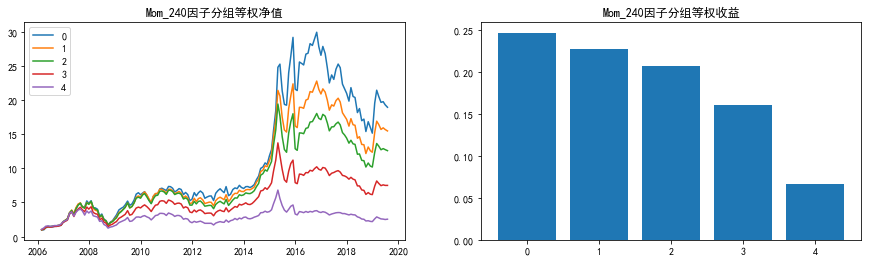

In [49]:
# 计算因子分组收益
def Cut(df,col,N):
    df_=df.copy()
    df_['G']=pd.qcut(df_[col],N,labels=False,duplicates='drop')
    return df_
def ComputYearlyRet(df,col):
    df_=df.sort_values('TRADE_DAYS').copy()
    last=(df_['TRADE_DAYS'].tolist()[-1]-df_['TRADE_DAYS'].tolist()[0]).days
    YearlyRet=(df_[col].tolist()[-1]/df_[col].tolist()[0])**(365.25/last)-1
    return YearlyRet

FacrotList=['Mom_'+str(c) for c in MomNList]
Used_FactorDf = BarraMomFct.copy()
for col in FacrotList:
    BarraFactorNextR_sub=Used_FactorDf[['S_INFO_WINDCODE','TRADE_DAYS','NextRet',col]].copy()
    BarraFactorNextR_sub0=BarraFactorNextR_sub.groupby('TRADE_DAYS').apply(Cut,col=col,N=5).reset_index(drop=True)
    BarraFactorNextR_sub1=BarraFactorNextR_sub0.groupby(['TRADE_DAYS','G']).mean().reset_index()
    FactorEquity=(BarraFactorNextR_sub1.pivot_table(index='TRADE_DAYS',columns='G',values='NextRet')+1).cumprod()
    FactorAvgR=BarraFactorNextR_sub1.groupby('G').mean()[['NextRet']]*12
    FactorYearlyR=FactorEquity.unstack().to_frame(col).reset_index().groupby('G').apply(ComputYearlyRet,col).to_frame(col)
    fig=plt.figure(figsize=(15,4))
    ax1=fig.add_subplot(1,2,1)
    ax1.plot(FactorEquity)
    ax1.legend(FactorEquity.columns,loc=0)
    plt.title('%s因子分组等权净值'%(col))
    ax2=fig.add_subplot(1,2,2)
    # 年化收益
    ax2.bar(FactorYearlyR.index,FactorYearlyR[col])
    # 平均收益
#     ax2.bar(FactorAvgR.index,FactorAvgR['NextRet'])
    plt.title('%s因子分组等权收益'%(col))
    plt.show()

A股似乎并不存在长期动量效应，长期表现出单调性较好的反转特性。

## 低波动异象分解

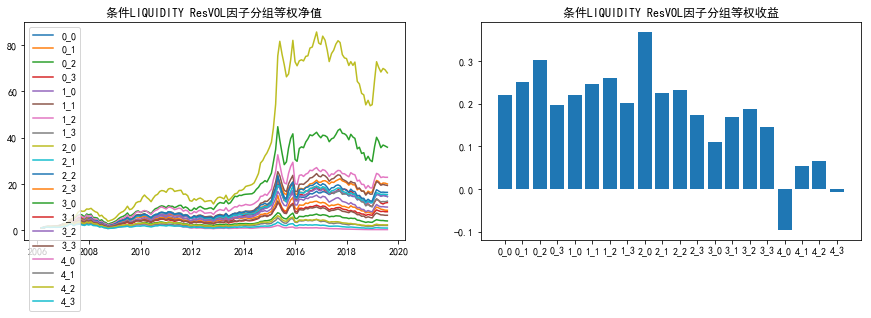

In [104]:
# 计算因子分组收益
def CutMulti(df,col,N):
    df_=df.copy()
    df_['G_%s'%(col)]=pd.qcut(df_[col],N,labels=False,duplicates='drop')
    return df_
def ComputYearlyRet(df,col):
    df_=df.sort_values('TRADE_DAYS').copy()
    last=(df_['TRADE_DAYS'].tolist()[-1]-df_['TRADE_DAYS'].tolist()[0]).days
    YearlyRet=(df_[col].tolist()[-1]/df_[col].tolist()[0])**(365.25/last)-1
    return YearlyRet

FacrotList=['Mom_'+str(c) for c in MomNList]
FacrotList=['ResVOL']
ConditionFct='LIQUIDITY'
Used_FactorDf = BarraMomFct.copy()
for col in FacrotList:
    BarraFactorNextR_sub=Used_FactorDf[['S_INFO_WINDCODE','TRADE_DAYS','NextRet',col,ConditionFct]].copy()
    BarraFactorNextR_sub0=BarraFactorNextR_sub.groupby('TRADE_DAYS').apply(CutMulti,col=col,N=4).reset_index(drop=True)
    BarraFactorNextR_sub1=BarraFactorNextR_sub0.groupby('TRADE_DAYS').apply(CutMulti,col=ConditionFct,N=5).reset_index(drop=True)
    BarraFactorNextR_sub2=BarraFactorNextR_sub1.groupby(['TRADE_DAYS','G_%s'%(col),'G_%s'%(ConditionFct)]).mean().reset_index()
    BarraFactorNextR_sub2['%s_Mom'%(ConditionFct)]=BarraFactorNextR_sub2['G_%s'%(ConditionFct)].apply(lambda x: str(x))+'_'+BarraFactorNextR_sub2['G_%s'%(col)].apply(lambda x: str(x))
    FactorEquity=(BarraFactorNextR_sub2.pivot_table(index='TRADE_DAYS',columns='%s_Mom'%(ConditionFct),values='NextRet')+1).cumprod()
    FactorAvgR=BarraFactorNextR_sub2.groupby('%s_Mom'%(ConditionFct)).mean()[['NextRet']]*12
    FactorYearlyR=FactorEquity.unstack().to_frame(col).reset_index().groupby('%s_Mom'%(ConditionFct)).apply(ComputYearlyRet,col).to_frame(col)
    fig=plt.figure(figsize=(15,4))
    ax1=fig.add_subplot(1,2,1)
    ax1.plot(FactorEquity)
    ax1.legend(FactorEquity.columns,loc=0)
    plt.title('条件%s %s因子分组等权净值'%(ConditionFct,col))
    ax2=fig.add_subplot(1,2,2)
    # 年化收益
    ax2.bar(FactorYearlyR.index,FactorYearlyR[col])
    # 平均收益
#     ax2.bar(FactorAvgR.index,FactorAvgR['NextRet'])
    plt.title('条件%s %s因子分组等权收益'%(ConditionFct,col))
    plt.show()

全横截面上低波动异象是存在的，与理论“波动越低，风险越低，期望收益越低”相反；  
使用流动性对波动因子进行double-sort后，低波动异象得到一定解释：在流动性从低到高的5组中，第1、2、4、5组的组内收益均呈现出一致的走势——组内前3组收益随着波动增加单调递增，最大波动组收益较低；  
固定流动性后，组内的收益随着波动的增大而增大，与理论是相符合的，最大（历史）波动组似乎不被投资者偏好，可能意味着过大的不确定性，尾部风险的发生侵蚀了预期收益的一部分。

In [85]:
Used_FactorDf

,S_INFO_WINDCODE,TRADE_DAYS,SIZE,BETA,MOM,ResVOL,NLSIZE,BM,LIQUIDITY,EARNnew,LEVERAGE,GROWTH,IND,NextRet,Mom_5,Mom_10,Mom_20,Mom_60,Mom_120,Mom_240
0,000001.SZ,2006-02-28,2.538907,0.945262,-0.690856,-0.827480,1.618078,-0.863697,-0.782584,-3.219360e-02,-0.184619,0.151646,1.0,-0.068728,7.418310e-03,9.791466e-02,9.791466e-02,0.208489,0.115886,0.115886
1,000001.SZ,2006-03-31,2.526245,1.614313,0.055642,-0.821216,1.476357,-0.769351,-0.990894,-8.264572e-02,-0.080293,0.102885,1.0,0.237025,9.502692e-03,2.740168e-02,-2.597800e-02,0.022457,0.105906,0.105906
2,000001.SZ,2006-04-28,2.573924,0.604137,-0.403693,0.109176,2.251744,-0.879114,-0.762321,-1.141300e-01,-0.219446,-0.049112,1.0,0.114194,1.520075e-01,1.503268e-01,2.370254e-01,0.240919,0.380006,0.412136
3,000001.SZ,2006-05-31,2.554813,0.694081,0.130765,-0.664125,2.038006,-0.755207,-1.122413,-3.030689e-02,-0.048003,-0.106342,1.0,-0.138915,9.339374e-02,6.678648e-02,2.488912e-01,0.294988,0.518985,0.518985
4,000001.SZ,2006-06-30,2.373564,-0.676347,-0.405889,-0.475022,1.398233,-0.486949,-0.952025,-1.119309e-02,-0.045905,-0.107602,1.0,-0.111146,3.706953e-02,6.330822e-02,-1.389154e-01,0.186821,0.215424,0.215424
5,000001.SZ,2006-07-31,2.350230,-0.237072,-0.916286,-1.181989,1.266681,-0.395610,-2.237236,3.895011e-02,-0.064975,-0.111511,1.0,0.075907,-7.439018e-02,-1.284285e-01,-1.703682e-01,-0.145051,0.049969,0.073436
6,000001.SZ,2006-08-31,2.384868,0.303317,-1.083079,-1.068091,1.431866,-0.411670,-1.942096,2.514718e-03,-0.052927,0.638640,1.0,0.128663,2.697178e-02,1.973387e-02,5.698089e-02,-0.176524,0.158616,0.060141
7,000001.SZ,2006-09-29,2.498304,0.338913,-0.792076,-0.641055,1.575092,-0.537754,-1.294112,-7.813711e-04,-0.046015,0.637949,1.0,0.170333,8.944868e-02,6.947137e-02,1.558236e-01,0.058381,0.261230,0.281017
8,000001.SZ,2006-10-31,2.612821,0.400457,-0.137019,0.036147,2.039375,-0.687415,-0.708537,-2.132785e-02,-0.191412,0.894899,1.0,0.324571,1.491142e-02,6.229712e-02,2.615515e-01,0.425418,0.138269,0.299358
9,000001.SZ,2006-11-30,2.596819,-0.045980,1.533240,0.915967,2.427784,-0.958576,0.083248,-2.133634e-02,-0.149788,0.896367,1.0,0.143882,-1.110223e-16,2.151607e-01,3.514991e-01,0.749641,0.440787,0.440787


In [28]:
BarraFactorNextR_sub0

,S_INFO_WINDCODE,TRADE_DAYS,NextRet,Mom_240,G
0,000001.SZ,2006-02-28,-0.068728,1.158863e-01,2
1,000002.SZ,2006-02-28,0.199594,5.251894e-01,4
2,000004.SZ,2006-02-28,-0.046529,-5.644599e-02,0
3,000005.SZ,2006-02-28,-0.004975,1.921708e-01,3
4,000006.SZ,2006-02-28,0.043733,8.966121e-01,4
5,000007.SZ,2006-02-28,-0.083846,-4.059041e-02,0
6,000008.SZ,2006-02-28,-0.064348,5.244755e-03,1
7,000009.SZ,2006-02-28,0.020681,2.360902e-01,3
8,000010.SZ,2006-02-28,-0.014175,-7.065868e-02,0
9,000011.SZ,2006-02-28,0.000000,2.735849e-02,1


In [79]:
BarraMomFct

,S_INFO_WINDCODE,TRADE_DAYS,SIZE,BETA,MOM,ResVOL,NLSIZE,BM,LIQUIDITY,EARN,EARNnew,LEVERAGE,GROWTH,IND,NextRet,Mom_20,Mom_40,Mom_60
0,000001.SZ,2006-02-28,2.538907,0.945262,-0.690856,-0.827480,1.618078,-0.863697,-0.782584,1.876991,-3.219360e-02,-0.184619,0.151646,1.0,-0.068728,9.791466e-02,1.287684e-01,0.208489
1,000001.SZ,2006-03-31,2.526245,1.614313,0.055642,-0.821216,1.476357,-0.769351,-0.990894,2.114205,-8.264572e-02,-0.080293,0.102885,1.0,0.237025,-2.597800e-02,3.147624e-03,0.022457
2,000001.SZ,2006-04-28,2.573924,0.604137,-0.403693,0.109176,2.251744,-0.879114,-0.762321,2.627604,-1.141300e-01,-0.219446,-0.049112,1.0,0.114194,2.370254e-01,2.048900e-01,0.240919
3,000001.SZ,2006-05-31,2.554813,0.694081,0.130765,-0.664125,2.038006,-0.755207,-1.122413,2.719357,-3.030689e-02,-0.048003,-0.106342,1.0,-0.138915,2.488912e-01,3.507380e-01,0.294988
4,000001.SZ,2006-06-30,2.373564,-0.676347,-0.405889,-0.475022,1.398233,-0.486949,-0.952025,4.244334,-1.119309e-02,-0.045905,-0.107602,1.0,-0.111146,-1.389154e-01,-4.058442e-02,0.186821
5,000001.SZ,2006-07-31,2.350230,-0.237072,-0.916286,-1.181989,1.266681,-0.395610,-2.237236,4.318281,3.895011e-02,-0.064975,-0.111511,1.0,0.075907,-1.703682e-01,-2.346219e-01,-0.145051
6,000001.SZ,2006-08-31,2.384868,0.303317,-1.083079,-1.068091,1.431866,-0.411670,-1.942096,3.992423,2.514718e-03,-0.052927,0.638640,1.0,0.128663,5.698089e-02,-9.056167e-02,-0.176524
7,000001.SZ,2006-09-29,2.498304,0.338913,-0.792076,-0.641055,1.575092,-0.537754,-1.294112,3.968935,-7.813711e-04,-0.046015,0.637949,1.0,0.170333,1.558236e-01,2.234342e-01,0.058381
8,000001.SZ,2006-10-31,2.612821,0.400457,-0.137019,0.036147,2.039375,-0.687415,-0.708537,1.887152,-2.132785e-02,-0.191412,0.894899,1.0,0.324571,2.615515e-01,3.245731e-01,0.425418
9,000001.SZ,2006-11-30,2.596819,-0.045980,1.533240,0.915967,2.427784,-0.958576,0.083248,1.017301,-2.133634e-02,-0.149788,0.896367,1.0,0.143882,3.514991e-01,5.911902e-01,0.749641


In [66]:
MomFct.sort_values(['S_INFO_WINDCODE','TRADE_DAYS'])

,S_INFO_WINDCODE,Mom_20,TRADE_DAYS,Mom_40,Mom_60
0,000001.SZ,0.0192493,2006-01-25,0.0967274,0.112083
1318,000001.SZ,0.0979147,2006-02-28,0.128768,0.208489
2634,000001.SZ,-0.025978,2006-03-31,0.00314762,0.0224575
3947,000001.SZ,0.237025,2006-04-28,0.20489,0.240919
5235,000001.SZ,0.248891,2006-05-31,0.350738,0.294988
6492,000001.SZ,-0.138915,2006-06-30,-0.0405844,0.186821
7749,000001.SZ,-0.170368,2006-07-31,-0.234622,-0.145051
9007,000001.SZ,0.0569809,2006-08-31,-0.0905617,-0.176524
10265,000001.SZ,0.155824,2006-09-29,0.223434,0.0583813
11522,000001.SZ,0.261551,2006-10-31,0.324573,0.425418


In [ ]:
http://www.kanzhiqiu.com/new/view/report/new_report_search.jsp?search_old=&page=1&totalPage=&pagesize=20&news_pagesize=25&dateoff=&tag=&showPageControl=true&doccolumnIds=&doctypeIds=&industry=&broker=&stock=&analyst_id=&analyst=&investrank=&industryrank=&sourceMktcode=&MYSTOCK=&SEARCH_LIST=&SEARCH_LISTID=&SEARCH_FIRST_COVER=&SEARCH_HAS_EVENT=&SEARCH_HGT=&SEARCH_GZ=&search_range=&searchAndOr=&SEARCHSAVEID=&pagenum=&LANGUAGE=&sort=&asc=&showAllsearchCondition=&_submited_=1&thumb=RICH&newsShowType=&tempStock=&tempBroker=&tempAnalyse=&clickFrom=0&search=barra&searchId=&lastReport=